In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization,LeakyReLU,Input, Lambda,Concatenate,Flatten
from  tensorflow.keras.models import Sequential,Model 
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import random

In [2]:
tf.enable_eager_execution()

In [ ]:
#we want to create a image colorization using GAN, I could have tried CNN but heard this works better
class ImageColorizer():
    def __init__(self):
        self.epochs = 5000
        self.image_size = 64
        self.batch_size = 50
        self.filter_size = 64
        self.kernel_size = 3
        self.learning_rate = 0.0002
        self.gen_optimizer = tf.train.AdamOptimizer(self.learning_rate,beta1=0.5)
        self.dis_optimizer = tf.train.AdamOptimizer(self.learning_rate,beta1=0.5)
    def generator_model(self):
        # generator is like this, we have grayscale image of size 50*50, and we first downsample and then upsample it
        #we use fully convolutional network, so we don't use Dense Layer here! 
        input_images = Input(shape=[32,32,1])
        #first layer
        layer1= Conv2D(self.filter_size,self.kernel_size,(2,2),padding='same',use_bias=False,kernel_initializer='random_uniform',activation=None)(input_images)
        layer1=LeakyReLU(0.2)(layer1)
        #shape = 16*16*64
        
        layer2= Conv2D(self.filter_size*2,self.kernel_size,(2,2),padding='same',use_bias=False,kernel_initializer='random_uniform',activation=None)(layer1)
        layer2=BatchNormalization()(layer2)
        layer2=LeakyReLU(0.2)(layer2)
        #shape =8*8*128
        
        layer3=Conv2D(self.filter_size*4,self.kernel_size,(2,2),padding='same',use_bias=False,kernel_initializer='random_uniform',activation=None)(layer2)
        layer3=BatchNormalization()(layer3)
        layer3=LeakyReLU(0.2)(layer3) 
        #shape = 4*4*256        
        
        up_layer5 = Conv2DTranspose(self.filter_size*2,self.kernel_size,strides = (2,2),padding='same',use_bias=False,activation=None)(layer3)
        up_layer5=BatchNormalization()(up_layer5)
        up_layer5=LeakyReLU(0.2)(up_layer5)
        #shape = 8*8*128
        up_layer_5_concat = Concatenate()([up_layer5, layer2])  


        up_layer6 = Conv2DTranspose(self.filter_size,self.kernel_size,strides = (2,2),padding='same',use_bias=False,activation=None)(up_layer_5_concat)
        up_layer6 =BatchNormalization()(up_layer6)
        up_layer6 =LeakyReLU(0.2)(up_layer6)

        #shape = 16*16*64
        up_layer_6_concat = Concatenate()([up_layer6, layer1])        
        
        up_layer7 = Conv2DTranspose(3,self.kernel_size,strides = (2,2),padding='same',use_bias=False,activation=None)(up_layer_6_concat)
        up_layer7 =BatchNormalization()(up_layer7)
        up_layer7 =LeakyReLU(0.2)(up_layer7)
        #shape = 32*32*3

        #shape = 32*32*3
        model = Model(input_images,up_layer7)
        return model
        
    def discriminator_model(self):
        # discriminator follows similar pattern, but has one sigmoid ouput whether the given network is from generator or from real data input
        input_images = Input(shape=[32,32,3])
        layer1= Conv2D(self.filter_size,self.kernel_size,(2,2),padding='same',use_bias=False,kernel_initializer='random_uniform',activation=None)(input_images)
        layer1=LeakyReLU(0.2)(layer1)
        #shape = 16*16*64
        layer2= Conv2D(self.filter_size*2,self.kernel_size,(2,2),padding='same',use_bias=False,kernel_initializer='random_uniform',activation=None)(layer1)
        layer2=BatchNormalization()(layer2)
        layer2=LeakyReLU(0.2)(layer2)
        #shape =8*8*128
        layer3=Conv2D(self.filter_size*4,self.kernel_size,(2,2),padding='same',use_bias=False,kernel_initializer='random_uniform',activation=None)(layer2)
        layer3=BatchNormalization()(layer3)
        layer3=LeakyReLU(0.2)(layer3) 
        #shape = 4*4*256        
        
        up_layer5 = Conv2DTranspose(self.filter_size*2,self.kernel_size,strides = (2,2),padding='same',use_bias=False,activation=None)(layer3)
        up_layer5=BatchNormalization()(up_layer5)
        up_layer5=LeakyReLU(0.2)(up_layer5)
        #shape = 8*8*128
        up_layer_5_concat = Concatenate()([up_layer5, layer2])  


        up_layer6 = Conv2DTranspose(self.filter_size,self.kernel_size,strides = (2,2),padding='same',use_bias=False,activation=None)(up_layer_5_concat)
        up_layer6 =BatchNormalization()(up_layer6)
        up_layer6 =LeakyReLU(0.2)(up_layer6)

        #shape = 16*16*64
        up_layer_6_concat = Concatenate()([up_layer6, layer1])        
        
        up_layer7 = Conv2DTranspose(self.filter_size,self.kernel_size,strides = (2,2),padding='same',use_bias=False,activation=None)(up_layer_6_concat)
        up_layer7 =BatchNormalization()(up_layer7)
        up_layer7 =LeakyReLU(0.2)(up_layer7)
        #shape = 32*32*64
        
        output = Conv2DTranspose(3,self.kernel_size,strides = (2,2),padding='same',use_bias=False,activation=None)(up_layer7)
        final_output = LeakyReLU(0.2)(output)
        #shape = 64*64*3
        output = Flatten()(final_output)
        
        sigmoid_output = Dense(1,activation='sigmoid')(output)  
        model = Model(input_images,sigmoid_output)
        return model
    
    def generator_loss(self,fake_output,generated_image, actual_image,regularizer_lambda=100):
        mse = tf.reduce_mean(regularizer_lambda*tf.keras.losses.mean_absolute_error(generated_image, actual_image))
        return tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(fake_output)*0.9,logits = fake_output) + mse
    
    def discriminator_loss(self,generated_image_from_generator,actual_image):
        actual_loss  = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(actual_image)*0.9, logits = actual_image )
        fake_loss  = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(generated_image_from_generator), logits = generated_image_from_generator)
        return actual_loss + fake_loss
    def draw_images(self,generator,input_image_test):
        predict_image= generator(input_image_test)
        plt.imshow(predict_image[0,:,:,:],cmap='gray')
        plt.show()
    def draw_dataset_image(self,grayscale_train_dataset,gray=False):
        index= 0 
        for x in grayscale_train_dataset:
            if not index:
                for i in range(10):
                    plt.subplot(5,5,i+1)
                    plt.axis('off')
                    if gray:
                        plt.imshow(x[i,:,:,0])
                    else:
                        plt.imshow(x[i,:,:,:])
            index = 1
            
        
        plt.show()
    def train(self,gray_scale_image_dataset,color_image_dataset,test_image):
        BUFFER_SIZE = 20000
        
        generator = self.generator_model()
        discriminator = self.discriminator_model()
        grayscale_train_dataset = tf.data.Dataset.from_tensor_slices(gray_scale_image_dataset).batch(self.batch_size)
        colored_image_train_dataset = tf.data.Dataset.from_tensor_slices(color_image_dataset).batch(self.batch_size)

        for eachEpoch in range(self.epochs):
            #this image is being drawn
            self.draw_dataset_image(grayscale_train_dataset,gray=True)
            self.draw_dataset_image(colored_image_train_dataset)
            for gray_scale_image,colored_image in zip(grayscale_train_dataset,colored_image_train_dataset):
                self.train_each_epoch(gray_scale_image,colored_image,generator,discriminator,eachEpoch)
            print("EPOCHS FINISHED = {}".format(eachEpoch))
            self.draw_images(generator,test_image)
        
    
    def train_each_epoch(self,gray_scale_image_dataset,color_image_dataset,generator,discriminator,epochNumber):
 
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_image = generator(gray_scale_image_dataset)
                
                real_output = discriminator(color_image_dataset)
                fake_output = discriminator(generated_image)

                gen_loss = self.generator_loss(fake_output,generated_image,color_image_dataset)
                dis_loss = self.discriminator_loss(fake_output,real_output)
            print ("Gen Loss = {} Dis Loss = {} ".format(gen_loss[0],dis_loss[0]))
            gen_gradients = gen_tape.gradient(gen_loss,generator.trainable_variables)
            disc_gradients = disc_tape.gradient(dis_loss,discriminator.trainable_variables)
            self.gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
            self.dis_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
        

In [262]:
#lets read the images
gray_scale_image_location = 'image-colorization/gray_scale.npy' 
colored_image_1_location = 'image-colorization/rgb_colored_images.npy'


In [263]:
gray_images  = np.load(gray_scale_image_location)
colored_image_1 = np.load(colored_image_1_location)

In [264]:
#resizing images! 
def imageResize(images):
    resize_array = []
    for index,img in enumerate(images):
        resized = cv2.resize(img,(32,32))                
        resize_array.append(resized)
    return np.array(resize_array)

In [265]:
gray_images_resized_type_unchanged = imageResize(gray_images)/255.0
color_images_resized_type_unchanged = imageResize(colored_image_1)/255.0

gray_images_resized_type=gray_images_resized_type_unchanged.astype(np.float32)
color_images_resized_type= imageResize(color_images_resized_type_unchanged).astype(np.float32)



In [272]:

gray_images_resized_type = np.reshape(gray_images_resized_type,(-1,32,32,1))
color_images_resized_type = np.reshape(color_images_resized_type,(-1,32,32,3))


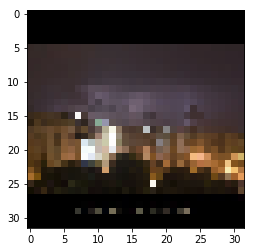

In [273]:
plt.imshow(color_images_resized_type[100,:,:,:])

In [284]:
test= cv2.imread('sanjiv.jpg',1)
test= cv2.cvtColor(test,cv2.COLOR_BGR2GRAY)
test = cv2.resize(test,(32,32))
test = np.reshape(test,(32,32,1)).astype(np.float32)
test = np.expand_dims(test,0)


In [285]:
image_colorizer = ImageColorizer()

gen = image_colorizer.generator_model()
dis = image_colorizer.discriminator_model()


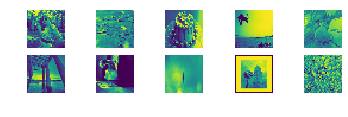

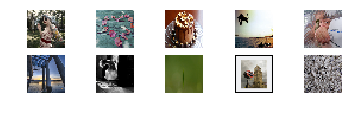

Gen Loss = [[39.246407]
 [39.246403]
 [39.246418]
 [39.246445]
 [39.246418]
 [39.24643 ]
 [39.246395]
 [39.246407]
 [39.246407]
 [39.246414]
 [39.24638 ]
 [39.24638 ]
 [39.246403]
 [39.2464  ]
 [39.246414]
 [39.246426]
 [39.24643 ]
 [39.24644 ]
 [39.246387]
 [39.24643 ]
 [39.246414]
 [39.24641 ]
 [39.246407]
 [39.246414]
 [39.246376]
 [39.246384]
 [39.246418]
 [39.2464  ]
 [39.246407]
 [39.24639 ]
 [39.24641 ]
 [39.246414]
 [39.246445]
 [39.24641 ]
 [39.2464  ]
 [39.24642 ]
 [39.24644 ]
 [39.24638 ]
 [39.246403]
 [39.246407]
 [39.24641 ]
 [39.24638 ]
 [39.24641 ]
 [39.246407]
 [39.24641 ]
 [39.24642 ]
 [39.246414]
 [39.246395]
 [39.2464  ]
 [39.246403]] Dis Loss = [[1.4974573]
 [1.4970315]
 [1.4982718]
 [1.4970548]
 [1.4971529]
 [1.4975834]
 [1.497347 ]
 [1.4977307]
 [1.4967291]
 [1.4971795]
 [1.4967704]
 [1.4964057]
 [1.4975877]
 [1.4978704]
 [1.4974008]
 [1.4981419]
 [1.4976424]
 [1.4979606]
 [1.4975479]
 [1.4975274]
 [1.4973027]
 [1.4973794]
 [1.4973669]
 [1.4978653]
 [1.4974062]
 [

KeyboardInterrupt: 

In [286]:
image_colorizer.train(gray_images_resized_type,color_images_resized_type,test)